# Explore Basis Trade Data


In [3]:

import load_bases_data
import os
import sys
import pandas as pd
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
# Set seaborn style
# sns.set()

# # Ensure 'src' is in sys.path
# sys.path.append(os.path.abspath("./src"))  # Add 'src' to the path

# Now import config from settings.py
from settings import config  # <- FIXED

# Set data directory
DATA_DIR = config("DATA_DIR")
MANUAL_DATA_DIR = config("MANUAL_DATA_DIR")
OUTPUT_DIR = config("OUTPUT_DIR")
data_dir = DATA_DIR

# Import required functions
from calc_treasury_data import calc_treasury
from calc_treasury_data import calc_treasury, parse_contract_date, interpolate_ois, rolling_outlier_flag


In [4]:
treasury_file = os.path.join(data_dir, "treasury_df.csv")
ois_file = os.path.join(data_dir, "ois_df.csv")
last_day_file = os.path.join(data_dir, "last_day_df.csv")
# Load data
df_treasury = pd.read_csv(treasury_file)
df_ois = pd.read_csv(ois_file)
df_last_day = pd.read_csv(last_day_file)

file_path = os.path.join(DATA_DIR, "treasury_sf_output.csv")

# Read the CSV file
df_output = pd.read_csv(file_path)
# Generate summary statistics
print("Summary Statistics for Treasury Data:")
print(df_treasury.describe())

print("\nSummary Statistics for OIS Data:")
print(df_ois.describe())

print("\nSummary Statistics for Last Day Data:")
print(df_last_day.describe())

print("\nSummary Statistics for Output Data:")
print(df_output.describe())

Summary Statistics for Treasury Data:
       Implied_Repo_1_10  Implied_Repo_1_2  Implied_Repo_1_20  \
count        5193.000000       5184.000000        5190.000000   
mean            1.427382          1.477007           1.237676   
std             2.110419          2.013668           2.490110   
min           -31.761600        -27.883070         -43.497260   
25%             0.003680          0.088243          -0.093777   
50%             0.586690          0.724335           0.420175   
75%             2.650660          2.568520           2.390123   
max            31.571160         31.526330          28.304200   

       Implied_Repo_1_30  Implied_Repo_1_5  Implied_Repo_2_10  \
count        3801.000000       5192.000000        5259.000000   
mean            0.121523          1.585025           1.496687   
std             2.915447          3.244307           1.856183   
min           -96.104580        -42.027090          -3.147350   
25%            -0.377820          0.104353         

In [5]:
def save_summary_to_latex(df, filename, caption, label):
    summary_statistics = df.describe().transpose()
    latex_table = summary_statistics.to_latex(float_format="%.2f", caption=caption, label=label)
    
    file_path = os.path.join(OUTPUT_DIR, filename)
    with open(file_path, "w") as f:
        f.write(latex_table)
    
    print(f"Saved LaTeX summary table: {file_path}")

# Save summary statistics as LaTeX files in OUTPUT_DIR
save_summary_to_latex(df_treasury, "summary_treasury.tex", "Summary Statistics of Treasury Data", "tab:summary_treasury")
save_summary_to_latex(df_ois, "summary_ois.tex", "Summary Statistics of OIS Data", "tab:summary_ois")
save_summary_to_latex(df_last_day, "summary_last_day.tex", "Summary Statistics of Last Day Data", "tab:summary_last_day")
save_summary_to_latex(df_output, "summary_output.tex", "Summary Statistics of Treasury SF Output Data", "tab:summary_output")

print("All LaTeX summary tables have been saved successfully in OUTPUT_DIR!")

Saved LaTeX summary table: \\pfileaws.ofr.treas.gov\OFR_UNIXHOME\jbejarano\GitRepositories\final_projects_2025\p12_treasury_sf_arb\_output\summary_treasury.tex
Saved LaTeX summary table: \\pfileaws.ofr.treas.gov\OFR_UNIXHOME\jbejarano\GitRepositories\final_projects_2025\p12_treasury_sf_arb\_output\summary_ois.tex
Saved LaTeX summary table: \\pfileaws.ofr.treas.gov\OFR_UNIXHOME\jbejarano\GitRepositories\final_projects_2025\p12_treasury_sf_arb\_output\summary_last_day.tex
Saved LaTeX summary table: \\pfileaws.ofr.treas.gov\OFR_UNIXHOME\jbejarano\GitRepositories\final_projects_2025\p12_treasury_sf_arb\_output\summary_output.tex
All LaTeX summary tables have been saved successfully in OUTPUT_DIR!


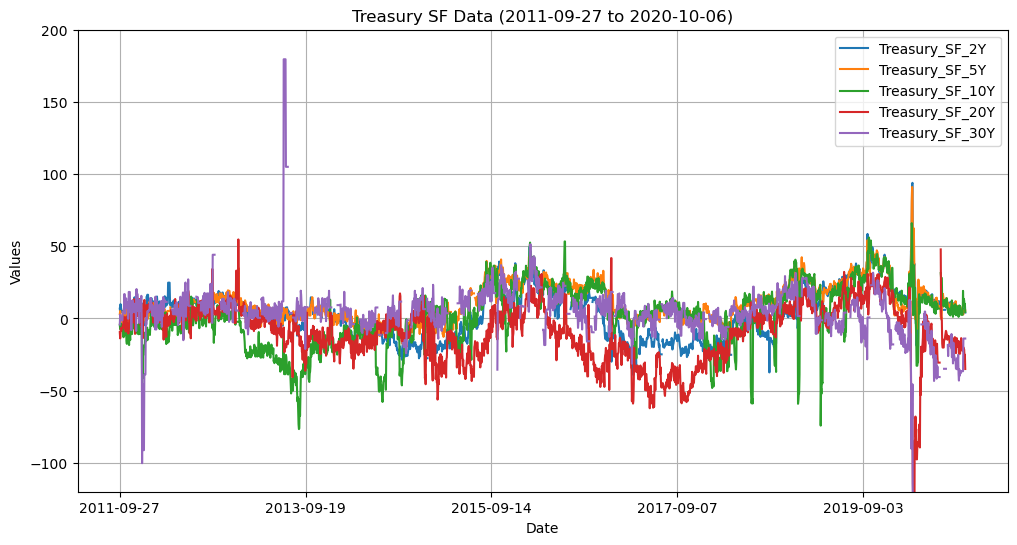

Plot has been saved successfully in \\pfileaws.ofr.treas.gov\OFR_UNIXHOME\jbejarano\GitRepositories\final_projects_2025\p12_treasury_sf_arb\_output as treasury_sf_data.png!


In [6]:
# Reindex columns in sorted order and filter only columns that match the pattern "Treasury_SF_*"

start_date = "2011-09-27"
end_date = "2020-10-06"
df_filtered = df_output[(df_output["Date"] >= start_date) & (df_output["Date"] <= end_date)]

# Plot the filtered data
df_filtered.set_index("Date").plot(figsize=(12, 6))  # Set Date as index for better plotting

# Set y-axis limits
plt.ylim(-120, 200)

# Set the file path for saving
plot_filename = os.path.join(OUTPUT_DIR, "treasury_sf_data.png")

# Your plotting code
plt.title("Treasury SF Data (2011-09-27 to 2020-10-06)")
plt.xlabel("Date")
plt.ylabel("Values")
plt.grid(True)

# Save the figure in OUTPUT_DIR
plt.savefig(plot_filename, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

print(f"Plot has been saved successfully in {OUTPUT_DIR} as treasury_sf_data.png!")

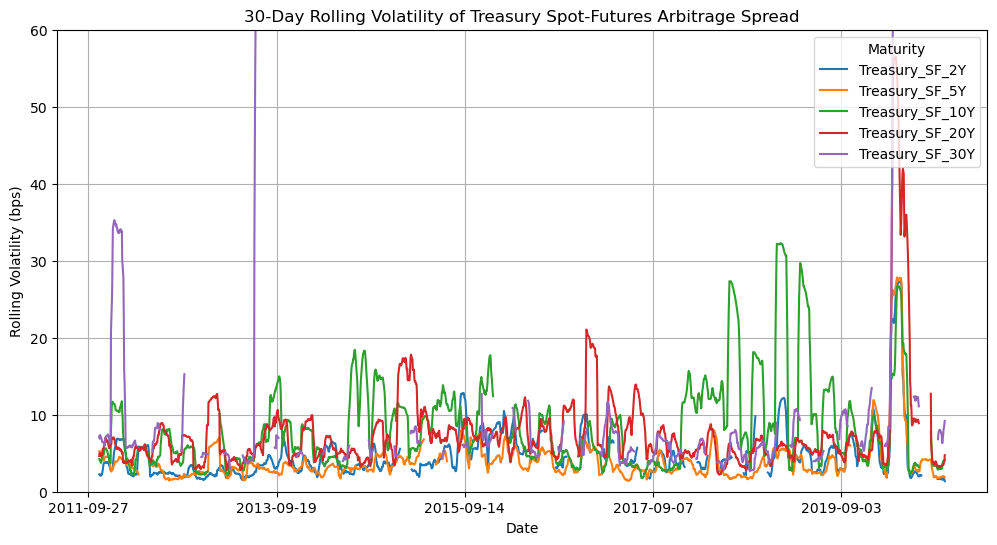

Plot has been saved successfully in \\pfileaws.ofr.treas.gov\OFR_UNIXHOME\jbejarano\GitRepositories\final_projects_2025\p12_treasury_sf_arb\_output as rolling_volatility_treasury_sf.png!


In [7]:
# Ensure Date is set as the index
df_filtered.set_index("Date", inplace=True)

# **Exclude non-numeric columns** before computing rolling standard deviation
df_numeric = df_filtered.select_dtypes(include=["number"])

# Compute rolling 30-day standard deviation (volatility)
rolling_volatility = df_numeric.rolling(window=30).std()

# Plot rolling volatility
plt.figure(figsize=(12, 6))
rolling_volatility.plot(ax=plt.gca())

# Your plotting code
plt.title("30-Day Rolling Volatility of Treasury Spot-Futures Arbitrage Spread")
plt.xlabel("Date")
plt.ylabel("Rolling Volatility (bps)")
plt.ylim(0, 60)

# Show legend
plt.legend(title="Maturity", loc="upper right")

# Save the figure in OUTPUT_DIR
plt.grid(True)
plt.savefig(plot_filename, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

print(f"Plot has been saved successfully in {OUTPUT_DIR} as rolling_volatility_treasury_sf.png!")

Until Now


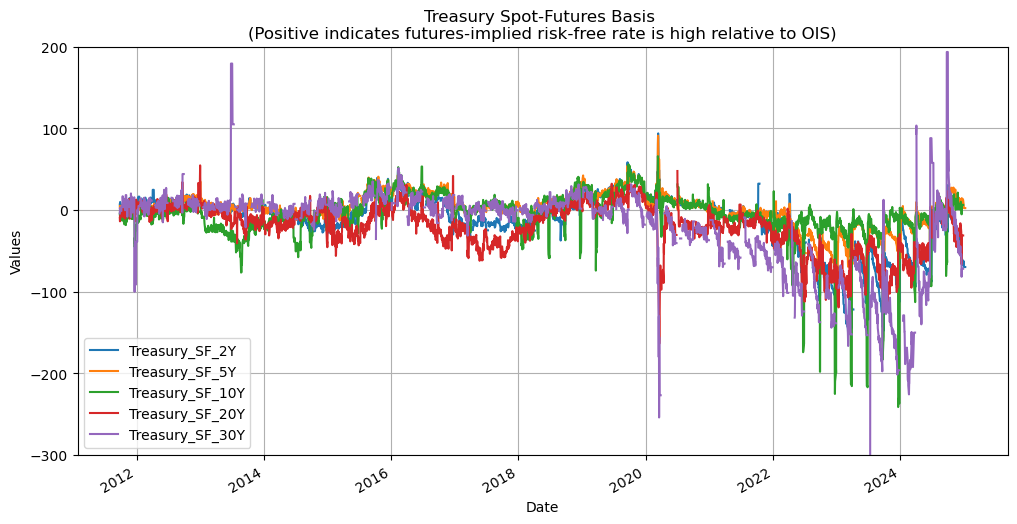

Plot has been saved successfully in \\pfileaws.ofr.treas.gov\OFR_UNIXHOME\jbejarano\GitRepositories\final_projects_2025\p12_treasury_sf_arb\_output as treasury_sf_data_2011-09-27_to_2025-03-28.png!


In [8]:


# Define directories
DATA_DIR = config("DATA_DIR")

# Define file path
output_file = os.path.join(DATA_DIR, "treasury_sf_output.csv")

# Load the dataset and ensure "Date" is parsed correctly
df_output = pd.read_csv(output_file, parse_dates=["Date"])

# Define start date and dynamically get the last available date
start_date = "2011-09-27"
end_date = df_output["Date"].max()  # Automatically detect the last date in dataset

# Filter data within the date range
df_filtered = df_output[(df_output["Date"] >= start_date) & (df_output["Date"] <= end_date)].copy()

# Plot the filtered data
df_filtered.set_index("Date").plot(figsize=(12, 6))  # Set Date as index for better plotting

# Set y-axis limits
plt.ylim(-300, 200)

# Define the plot filename dynamically based on the date range
plot_filename = os.path.join(OUTPUT_DIR, f"treasury_sf_data_{start_date}_to_{end_date.date()}.png")

# Your plotting code
plt.title(f"Treasury Spot-Futures Basis \n(Positive indicates futures-implied risk-free rate is high relative to OIS)")  # Format title dynamically
plt.xlabel("Date")
plt.ylabel("Values")
plt.grid(True)

# Save the figure in OUTPUT_DIR
plt.savefig(plot_filename, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

print(f"Plot has been saved successfully in {OUTPUT_DIR} as treasury_sf_data_{start_date}_to_{end_date.date()}.png!")

In [9]:
import matplotlib.dates as mdates

# Define start date and dynamically get the last available date
start_date = "2022"
end_date = df_output["Date"].max()

# Filter data within the date range
df_filtered = df_output[(df_output["Date"] >= start_date) & (df_output["Date"] <= end_date)].copy()


In [10]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 814 entries, 4424 to 5237
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             814 non-null    datetime64[ns]
 1   Treasury_SF_2Y   733 non-null    float64       
 2   Treasury_SF_5Y   747 non-null    float64       
 3   Treasury_SF_10Y  752 non-null    float64       
 4   Treasury_SF_20Y  752 non-null    float64       
 5   Treasury_SF_30Y  658 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 44.5 KB


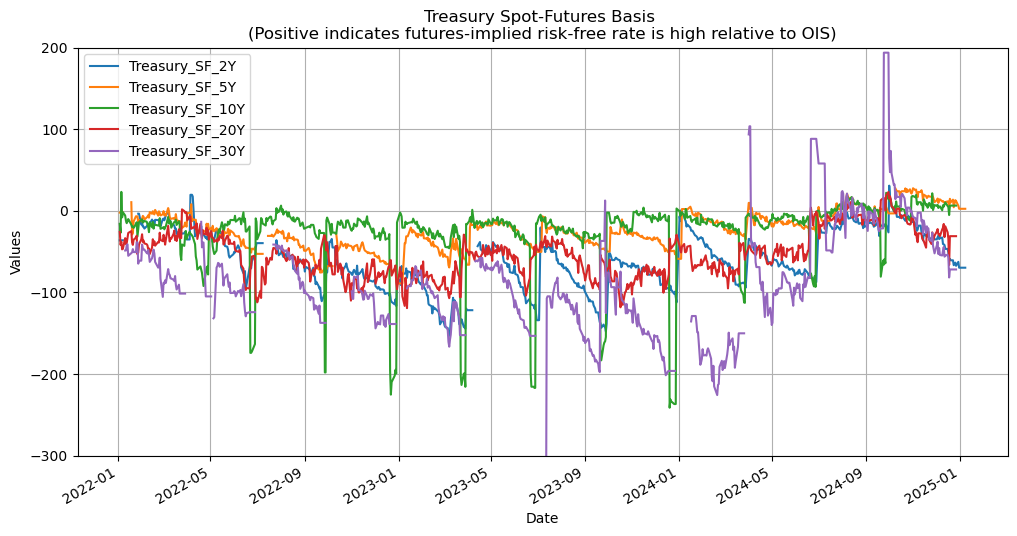

Plot has been saved successfully in \\pfileaws.ofr.treas.gov\OFR_UNIXHOME\jbejarano\GitRepositories\final_projects_2025\p12_treasury_sf_arb\_output as treasury_sf_data_2022_to_2025-03-28.png!


In [11]:
import matplotlib.dates as mdates

# Define start date and dynamically get the last available date
start_date = "2022"
end_date = df_output["Date"].max()

# Filter data within the date range
df_filtered = df_output[(df_output["Date"] >= start_date) & (df_output["Date"] <= end_date)].copy()

# Plot the filtered data
ax = df_filtered.set_index("Date").plot(figsize=(12, 6))

# Set y-axis limits
ax.set_ylim(-300, 200)

# # Set x-axis major ticks at every 6 months (Jan 1 and June 1)
# locator = mdates.MonthLocator(bymonth=(1, 6), bymonthday=1)
# formatter = mdates.DateFormatter('%b %Y')
# ax.xaxis.set_major_locator(locator)
# ax.xaxis.set_major_formatter(formatter)

# # Rotate x-axis labels for better readability
# plt.xticks(rotation=45)


# Define the plot filename dynamically based on the date range
plot_filename = os.path.join(OUTPUT_DIR, f"treasury_sf_data_{start_date}_to_{end_date.date()}.png")

# Your plotting code
plt.title(f"Treasury Spot-Futures Basis \n(Positive indicates futures-implied risk-free rate is high relative to OIS)")  # Format title dynamically
plt.xlabel("Date")
plt.ylabel("Values")
plt.grid(True)

# Save the figure in OUTPUT_DIR
plt.savefig(plot_filename, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

print(f"Plot has been saved successfully in {OUTPUT_DIR} as treasury_sf_data_{start_date}_to_{end_date.date()}.png!")


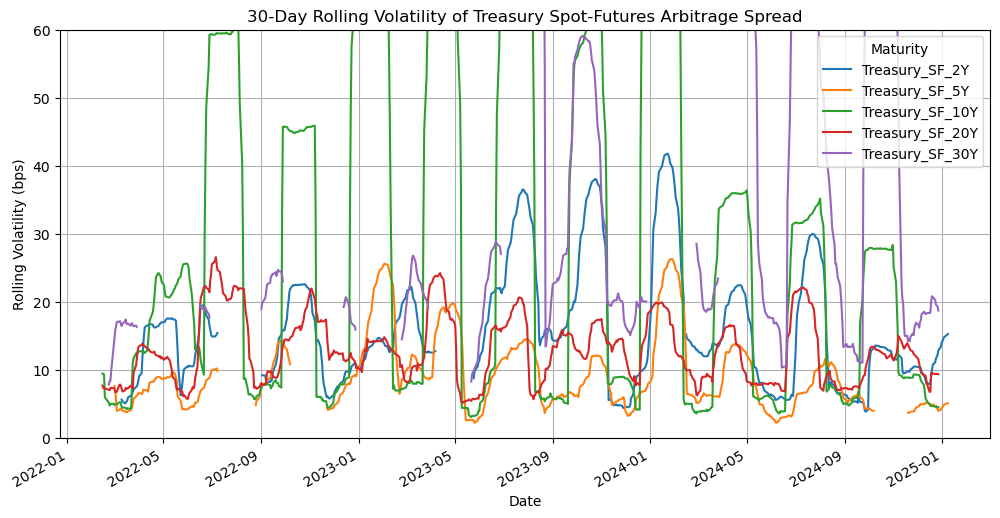

Plot has been saved successfully in \\pfileaws.ofr.treas.gov\OFR_UNIXHOME\jbejarano\GitRepositories\final_projects_2025\p12_treasury_sf_arb\_output as rolling_volatility_treasury_sf_now.png!


In [12]:
# Ensure Date is set as the index
df_filtered.set_index("Date", inplace=True)

# **Exclude non-numeric columns** before computing rolling standard deviation
df_numeric = df_filtered.select_dtypes(include=["number"])

# Compute rolling 30-day standard deviation (volatility)
rolling_volatility = df_numeric.rolling(window=30).std()

# Plot rolling volatility
plt.figure(figsize=(12, 6))
rolling_volatility.plot(ax=plt.gca())

# Define the plot filename
plot_filename = os.path.join(OUTPUT_DIR, "rolling_volatility_treasury_sf_now.png")

# Set plot title and labels
plt.title("30-Day Rolling Volatility of Treasury Spot-Futures Arbitrage Spread")
plt.xlabel("Date")
plt.ylabel("Rolling Volatility (bps)")
plt.ylim(0, 60)

# Show legend
plt.legend(title="Maturity", loc="upper right")

# Show grid
plt.grid(True)

# Save the figure in OUTPUT_DIR
plt.savefig(plot_filename, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

print(f"Plot has been saved successfully in {OUTPUT_DIR} as rolling_volatility_treasury_sf_now.png!")